In [1]:
import cv2, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from poe.bulk.predictions import *
from itertools import groupby
from pathlib import Path
from poe.bulk.image_cutter import *
import hashlib
from collections import defaultdict
import easyocr
from Levenshtein.StringMatcher import StringMatcher
from poe.ninja import retrieve_prices
from poe.valuation import own_valuations

display = pd.options.display

display.max_columns = 1000
display.max_rows = 10000
reader = easyocr.Reader(
    ["en"]
)  # this needs to run only once to load the model into memory
plt.style.use("dark_background")
%matplotlib inline

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [2]:
reader = easyocr.Reader(
    ["en"]
)  # this needs to run only once to load the model into memory
prices = retrieve_prices()
valuations = own_valuations(prices)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Retrieving prices from ninja....................Done in 2.44 seconds
Evaluating
Scarabs
Div Cards
Splinters
Currency
Done


In [3]:
def parse_numbers(img):
    assert img.shape[0] * img.shape[1] > 0
    cols_of_interest = [1, 6, 8, 11, 13, 14, 19, 21, 24, 26]

    try:
        frags = cut_image_to_frags(img)
    except Exception as e:
        print(f"could not be processed:{e}")
        plt.figure(figsize=(20, 20))
        plt.imshow(img)
        raise

    results = defaultdict(dict)
    for col in cols_of_interest:
        for row, frag in enumerate(frags[col]):
            _frag = normalize_frag(frag, target=(32, 80))
            #             plt.figure()
            #             plt.imshow(_frag)
            #             plt.show()
            result = predict_wrapper(_frag)
            #             input(f'{result} next?')
            results[col][row] = result.replace("..", "9.")
    return results


def parse_text(img, reader):
    assert img.shape[0] * img.shape[1] > 0
    cols_of_interest = [4, 17]
    try:
        frags = cut_image_to_frags(img)
    except Exception as e:
        print(f"{path,img_hash} could not be processed:{e}")
        plt.figure(figsize=(20, 20))
        plt.imshow(img)
        raise
    results = defaultdict(dict)
    for col in cols_of_interest:

        for row, frag in enumerate(frags[col]):
            result = reader.readtext(frag)
            if result:
                results[col][row] = result[0][1]
    return results

/Users/swozny/work/poe/venv2/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


,1,6,8,11,13,14,19,21,24,26
0,11,2,1.8,19.8,0.2,5,3,2.7,13.5,0.14
1,6,2,1.8,10.8,0.11,2,5,4.5,9,0.09
2,9,1,0.9,8.1,0.08,8,1,0.9,7.2,0.07
3,1,8,7.2,7.2,0.07,7,1,0.9,6.3,0.06
4,1,6,5.4,5.4,0.05,2,3,2.7,5.4,0.05


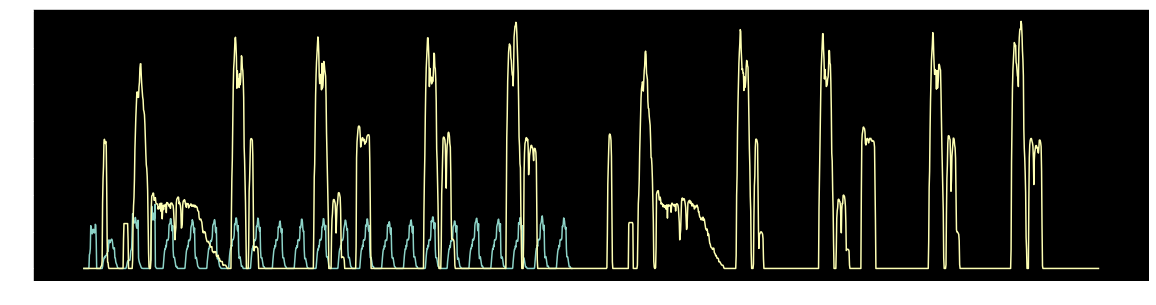

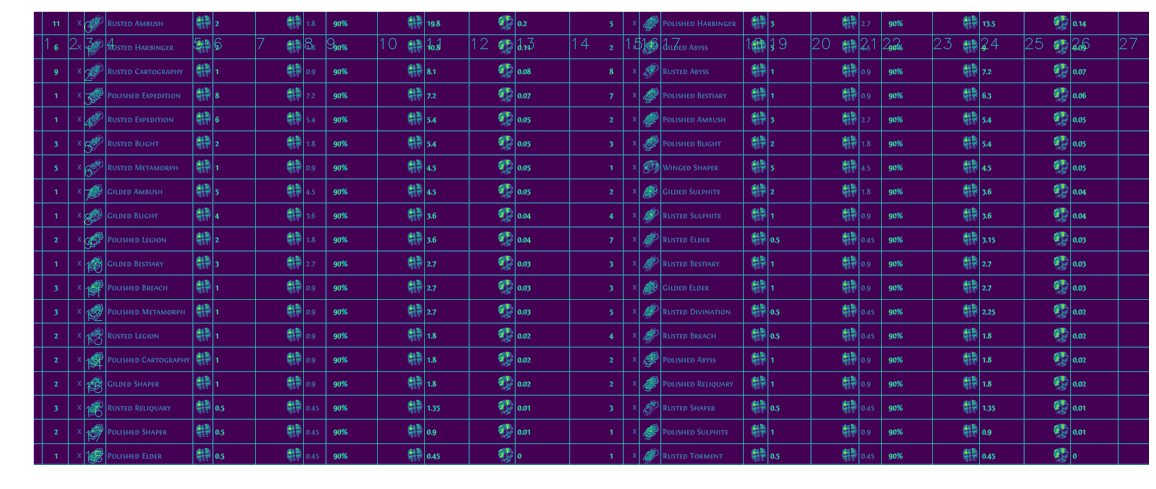

In [4]:
path = "poe/bulk/data/tabs/asd.png"

img = cv2.imread(path)
results = parse_numbers(img)
numbers = pd.DataFrame(results)
numbers.head()

In [1]:
img = cv2.imread(path)
strings = pd.DataFrame(parse_text(img, reader))
strings.head()

NameError: name 'cv2' is not defined

In [ ]:
def map_read_to_ninja(read_from_picture, prices):

    raw = str(read_from_picture).lower()
    augmented = [f"the {raw}", f"{raw} scarab", raw]
    asd = max(
        [
            (
                StringMatcher(seq1=candidate, seq2=str(y).lower()).ratio(),
                y,
                read_from_picture,
            )
            for y in prices
            for candidate in augmented
        ]
    )[1]
    return asd


from functools import partial

strings_processed = strings.applymap(partial(map_read_to_ninja, prices=prices))
strings_processed.head()

In [ ]:
df = numbers.join(strings_processed)
df = df[sorted(df.columns)].rename(
    {
        1: "quantity",
        4: "name",
        6: "price",
        8: "asking_price",
        11: "total_chaos",
        13: "total_exalt",
        14: "quantity",
        17: "name",
        19: "price",
        21: "asking_price",
        24: "total_chaos",
        26: "total_exalt",
    },
    axis=1,
)
left = df.iloc[:, int(len(df.columns) / 2) :]
right = df.iloc[:, : int(len(df.columns) / 2)]
df = pd.concat([left, right], ignore_index=True, axis=0)
df = df[df.price != ""]
df["total_chaos"] = df.total_chaos.astype(float)
df = df.set_index("name").astype("float")
df["total_chaos"] = df.quantity * df.asking_price
print(df["total_chaos"].sum())
df.head()

In [ ]:
df = df.join(pd.Series(valuations, name="valuation")).drop(
    ["total_exalt", "total_chaos"], axis=1
)
df["valuation"] = df["valuation"].fillna(df.price)
df = df.rename({"price": "ninja"}, axis=1)
df.head()

In [ ]:
df["own"] = df.quantity * df.valuation
df["their"] = df.quantity * df.asking_price
df["ratio"] = df.their / df.own
df.sort_values("own", ascending=False).query("ratio<0.7")

In [ ]:
print((df.quantity * df.valuation).sum())
(df.quantity * df.valuation).sort_values(ascending=False)

In [ ]:
(df.quantity * df.valuation - df.quantity * df.asking_price).sum()

In [ ]:
(df.quantity * df.ninja).sum() / (df.quantity * df.valuation).sum()